In [1]:
%load_ext autoreload
%autoreload 2
    
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import sys; sys.path.append("../../")
import pykappa
import tifffile

# Set paths
data_dir = Path("/home/hadim/.data/Postdoc/Kappa/sine_curve")

if data_dir.name.endswith("_SDM"):
  figure_dir = Path("Figures_SDM")
else:
  figure_dir = Path("Figures")
figure_dir.mkdir(exist_ok=True)

# Generated during dataset build
theoretical_curvatures_path = data_dir / "Original_Curve.csv"
figure_dir

PosixPath('Figures')

---
## Single Curve Analysis

Plot curvature values and residuals for on single initialization curve in one image.

In [3]:
# Here we define the examples shown in the last figures of the paper.
# This is dependent on the dataset you are working with.

dataset_types = ['variable_snr', 'variable_pixel_size', 'variable_initial_position',
                 'variable_psf_size']
feature_types = [int, float, float, float]

examples = {}

examples['variable_snr'] = {}
examples['variable_snr']['curve_id'] = 23
examples['variable_snr']['image_id'] = [12, 25]

examples['variable_pixel_size'] = {}
examples['variable_pixel_size']['curve_id'] = 23
examples['variable_pixel_size']['image_id'] = [5, 15]

examples['variable_initial_position'] = {}
examples['variable_initial_position']['curve_id'] = 16
examples['variable_initial_position']['image_id'] = [1, 8]

examples['variable_psf_size'] = {}
examples['variable_psf_size']['curve_id'] = 8
examples['variable_psf_size']['image_id'] = [1, 6]

In [12]:
dataset_type = 'variable_snr'
image_position = 0  # 0 or 1

image_id = examples[dataset_type]['image_id'][image_position]
curve_id = examples[dataset_type]['curve_id']

feature_type = feature_types[dataset_types.index(dataset_type)]

figure_output_dir = figure_dir / dataset_type
figure_output_dir.mkdir(exist_ok=True)

path_dir = data_dir / dataset_type
fname = sorted(list(path_dir.glob("*.tif")))[image_id]
print(fname)

# Load curvatures
curvatures = pd.read_csv(fname.with_suffix('.csv'))

# Get sampled theoretical curve
new_x = np.arange(0, 15, 0.01)  # um
theoretical_sampled = pykappa.analysis.get_theoretical_sampled(new_x, theoretical_curvatures_path)

# Get sampled curves and residuals
data = pykappa.analysis.get_sampled_and_residuals(curvatures, theoretical_sampled, fname, feature_type)

/home/hadim/.data/Postdoc/Kappa/sine_curve_SDM/variable_snr/snr_12_dB.tif


CURVE 4
Absolute Error = 0.06033059013223397 um^-1
Pearson Coefficient = 0.9564114642314079


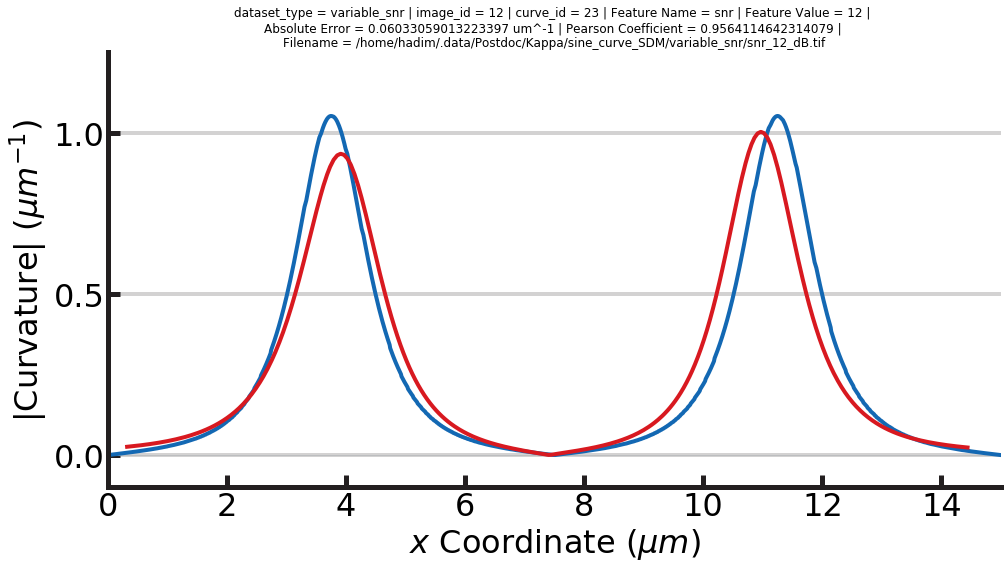

In [13]:
# Select one curve and plot it
curve_name = data['curve_name'].unique()[curve_id]
df = data[data['curve_name'] == curve_name]
print(curve_name)

absolute_error = df['residuals_absolute'].mean()
pearson_coef = theoretical_sampled["k"].corr(df["k"], method='pearson')

print(f'Absolute Error = {absolute_error} um^-1')
print(f'Pearson Coefficient = {pearson_coef}')

feature_name = df['feature_name'].iloc[0]
feature_value = df['feature'].iloc[0]

base_size = 16
fig, ax = plt.subplots(figsize=(base_size, base_size/2))

ax.axhline(0, color="#bcbec0ff", lw=1)

ax.plot(theoretical_sampled["x"], theoretical_sampled["k"], color="#1368b3ff", lw=4)
ax.plot(df["x"], df["k"], color="#d81920ff", lw=4)
#ax.plot(df["x"], df["residuals"], color="#85bc3bff", lw=4)

ax.set_xticks(np.arange(0, 16, 2))
ax.set_yticks(np.arange(0, 1.26, 0.5))

ax.set_ylim(-0.1, 1.25)
ax.set_xlim(0, 15)

ax.set_ylabel("|Curvature| ($μm^{-1}$)")
ax.set_xlabel("$x$ Coordinate ($μm$)")

# Save metadata together with the image
metadata = ''
metadata += f'dataset_type = {dataset_type} | '
metadata += f'image_id = {image_id} | '
metadata += f'curve_id = {curve_id} | '
metadata += f'Feature Name = {feature_name} | '
metadata += f'Feature Value = {feature_value} | '
metadata += '\n'
metadata += f'Absolute Error = {absolute_error} um^-1 | '
metadata += f'Pearson Coefficient = {pearson_coef} | '
metadata += '\n'
metadata += f'Filename = {fname}'
ax.set_title(metadata)

kwargs = dict(font="DejaVu Sans", font_size_ratio=1, axes_color="#231f20ff",
              x_axis_grid=False, y_axis_grid=True, tick_width=5)
pykappa.mpl.set_ax_style(ax, **kwargs)

fig_name = f"single-feature-{feature_name}-{feature_value}-curve_id-{curve_id}.svg"
figure_path = figure_output_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

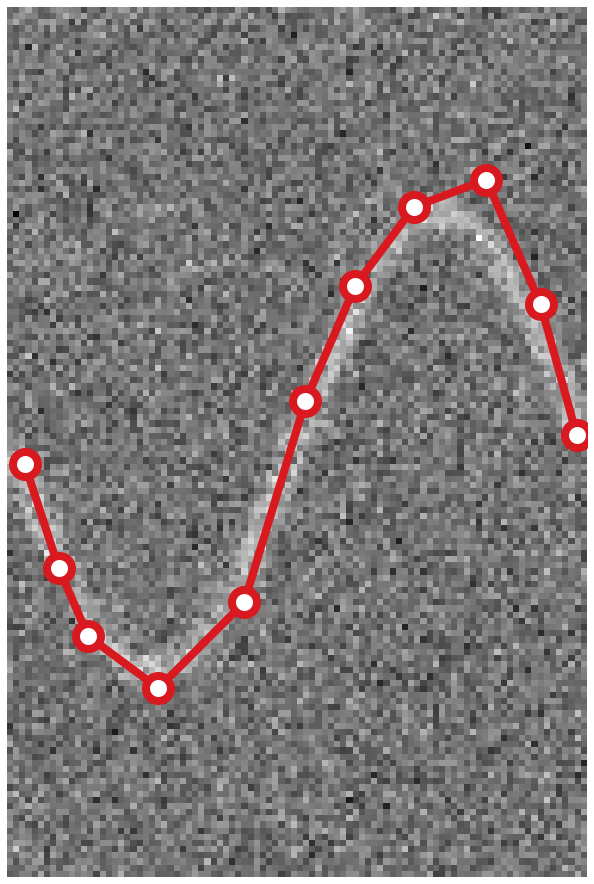

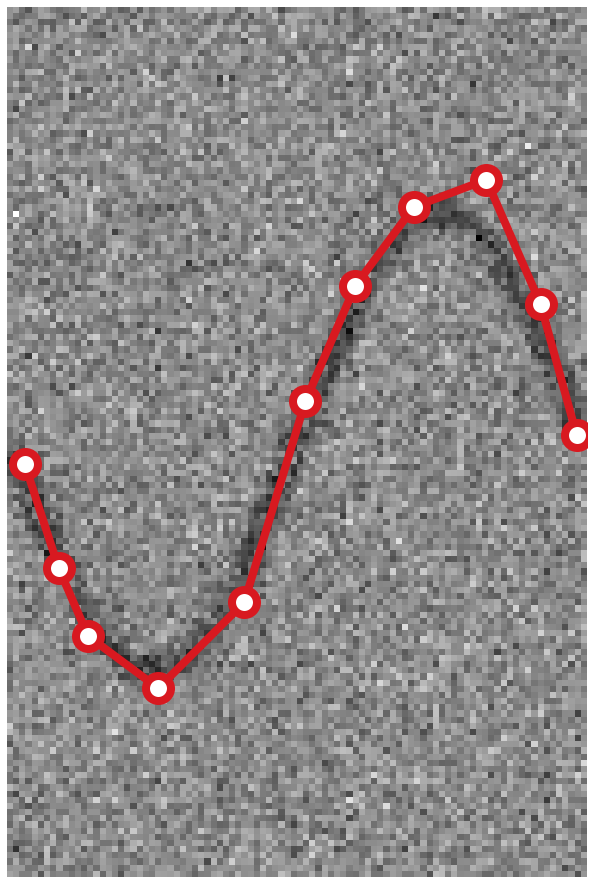

In [14]:
# Plot the image and its curve

image = tifffile.imread(str(fname))
curves = pykappa.io.parse_kappa(fname.with_suffix('.kapp'))
curve = curves[curve_id]
pos = curve['curve_pos']

# Save raw image
tifffile.imsave(str(figure_path.with_suffix(".IMAGE.tif")), image)
tifffile.imsave(str(figure_path.with_suffix(".IMAGE_INVERTED.tif")), np.invert(image))

base_size = 16
fig, ax = plt.subplots(figsize=(base_size, base_size))

ax.imshow(image, aspect='equal', interpolation='none', cmap='gray')
ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
        markeredgecolor='#d81920ff',
        markerfacecolor='#ffffff',
        markeredgewidth=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

fig.savefig(figure_path.with_suffix(".CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

base_size = 16
fig, ax = plt.subplots(figsize=(base_size, base_size))

ax.imshow(np.invert(image), aspect='equal', interpolation='none', cmap='gray')
ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
        markeredgecolor='#d81920ff',
        markerfacecolor='#ffffff',
        markeredgewidth=8)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
fig.savefig(figure_path.with_suffix(".IMAGE_INVERTED.CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

## Batch single examples analysis

In [ ]:
for dataset_type, params in examples.items():
  print(dataset_type)
  for image_id in params['image_id']:
    curve_id = examples[dataset_type]['curve_id']

    feature_type = feature_types[dataset_types.index(dataset_type)]

    figure_output_dir = figure_dir / dataset_type
    figure_output_dir.mkdir(exist_ok=True)

    path_dir = data_dir / dataset_type
    fname = sorted(list(path_dir.glob("*.tif")))[image_id]
    print(fname)

    # Load curvatures
    curvatures = pd.read_csv(fname.with_suffix('.csv'))

    # Get sampled theoretical curve
    new_x = np.arange(0, 15, 0.01)  # um
    theoretical_sampled = pykappa.analysis.get_theoretical_sampled(new_x, theoretical_curvatures_path)

    # Get sampled curves and residuals
    data = pykappa.analysis.get_sampled_and_residuals(curvatures, theoretical_sampled, fname, feature_type)
    
    # Select one curve and plot it
    curve_name = data['curve_name'].unique()[curve_id]
    df = data[data['curve_name'] == curve_name]
    print(curve_name)

    absolute_error = df['residuals_absolute'].mean()
    pearson_coef = theoretical_sampled["k"].corr(df["k"], method='pearson')

    print(f'Absolute Error = {absolute_error} um^-1')
    print(f'Pearson Coefficient = {pearson_coef}')

    feature_name = df['feature_name'].iloc[0]
    feature_value = df['feature'].iloc[0]

    base_size = 16
    fig, ax = plt.subplots(figsize=(base_size, base_size/2))

    ax.axhline(0, color="#bcbec0ff", lw=1)

    ax.plot(theoretical_sampled["x"], theoretical_sampled["k"], color="#1368b3ff", lw=4)
    ax.plot(df["x"], df["k"], color="#d81920ff", lw=4)
    #ax.plot(df["x"], df["residuals"], color="#85bc3bff", lw=4)

    ax.set_xticks(np.arange(0, 16, 2))
    ax.set_yticks(np.arange(0, 1.26, 0.5))

    ax.set_ylim(-0.1, 1.25)
    ax.set_xlim(0, 15)

    ax.set_ylabel("|Curvature| ($μm^{-1}$)")
    ax.set_xlabel("$x$ Coordinate ($μm$)")

    # Save metadata together with the image
    metadata = ''
    metadata += f'dataset_type = {dataset_type} | '
    metadata += f'image_id = {image_id} | '
    metadata += f'curve_id = {curve_id} | '
    metadata += f'Feature Name = {feature_name} | '
    metadata += f'Feature Value = {feature_value} | '
    metadata += '\n'
    metadata += f'Absolute Error = {absolute_error} um^-1 | '
    metadata += f'Pearson Coefficient = {pearson_coef} | '
    metadata += '\n'
    metadata += f'Filename = {fname}'
    ax.set_title(metadata)

    kwargs = dict(font="DejaVu Sans", font_size_ratio=1, axes_color="#231f20ff",
                  x_axis_grid=False, y_axis_grid=True, tick_width=5)
    pykappa.mpl.set_ax_style(ax, **kwargs)

    fig_name = f"single-feature-{feature_name}-{feature_value}-curve_id-{curve_id}.svg"
    figure_path = figure_output_dir / fig_name
    fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
    
    # Plot the image and its curve

    image = tifffile.imread(str(fname))
    curves = pykappa.io.parse_kappa(fname.with_suffix('.kapp'))
    curve = curves[curve_id]
    pos = curve['curve_pos']

    # Save raw image
    tifffile.imsave(str(figure_path.with_suffix(".IMAGE.tif")), image)
    tifffile.imsave(str(figure_path.with_suffix(".IMAGE_INVERTED.tif")), np.invert(image))

    base_size = 16
    fig, ax = plt.subplots(figsize=(base_size, base_size))

    ax.imshow(image, aspect='equal', interpolation='none', cmap='gray')
    ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
            markeredgecolor='#d81920ff',
            markerfacecolor='#ffffff',
            markeredgewidth=8)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

    fig.savefig(figure_path.with_suffix(".CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
    
    base_size = 16
    fig, ax = plt.subplots(figsize=(base_size, base_size))

    ax.imshow(np.invert(image), aspect='equal', interpolation='none', cmap='gray')
    ax.plot(pos[:, 0], pos[:, 1], color="#d81920ff", lw=8, marker='o', ms=25,
            markeredgecolor='#d81920ff',
            markerfacecolor='#ffffff',
            markeredgewidth=8)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    fig.savefig(figure_path.with_suffix(".IMAGE_INVERTED.CONTROL_POINTS.png"), dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

---
## Analyze the "Variable SNR" dataset

In [2]:
experiment_name = 'variable_snr'
feature_type = float

path_dir = data_dir / experiment_name
fnames = list(path_dir.glob("*.tif"))

data = pd.DataFrame()
for fname in tqdm(fnames, total=len(fnames)):
    
    # Load curvatures
    curvatures = pd.read_csv(fname.with_suffix('.csv'))

    # Get sampled theoretical curve
    new_x = np.arange(0, 15, 0.01)  # um
    theoretical_sampled = pykappa.analysis.get_theoretical_sampled(new_x, theoretical_curvatures_path)

    # Get sampled curves and residuals
    results = pykappa.analysis.get_sampled_and_residuals(curvatures, theoretical_sampled, fname, feature_type)
    
    # Average values by curve name
    datum = results.groupby('curve_name').mean()
    
    # Compute Pearson coefficient for each curve
    datum['pearson_coef'] = results.groupby('curve_name').apply(lambda x: theoretical_sampled["k"].corr(x["k"], method='pearson'))

    from scipy.signal import argrelmax
    from scipy.spatial import distance
    from scipy.signal import savgol_filter

    for name, curvature in results.groupby('curve_name'):

      theoretical_idxs = argrelmax(theoretical_sampled['k'].values)[0]
      theoretical_curvature_values = theoretical_sampled.iloc[theoretical_idxs]['k'].values

      idxs = argrelmax(curvature['k'].values)[0]
      if len(idxs) > 2:
        idxs = argrelmax(savgol_filter(curvature['k'], 81, 3))[0]
      curvature_values = np.sort(curvature.iloc[idxs]['k'])[-2:]
      
      datum.loc[name, 'peak_curvature'] = curvature_values.mean()
      datum.loc[name, 'theoretical_peak_curvature'] = theoretical_curvature_values.mean()
      
    #datum['peak_error_absolute'] = np.abs(datum['peak_curvature'] - datum['theoretical_peak_curvature'])
        
    data = data.append(datum.reset_index())

/home/hadim/local/conda/envs/kappa/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/home/hadim/local/conda/envs/kappa/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


In [3]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['k'] - theoretical_sampled['k'].mean()).abs()
grouped = grouped.reset_index()

In [15]:
df = grouped.groupby('feature').mean()
df.loc[0:5].mean()

x                             7.495000
k                             0.266334
residuals                     0.000404
residuals_absolute            0.109660
pearson_coef                  0.830525
peak_curvature                0.921669
theoretical_peak_curvature    1.052713
average_error                 0.022139
dtype: float64

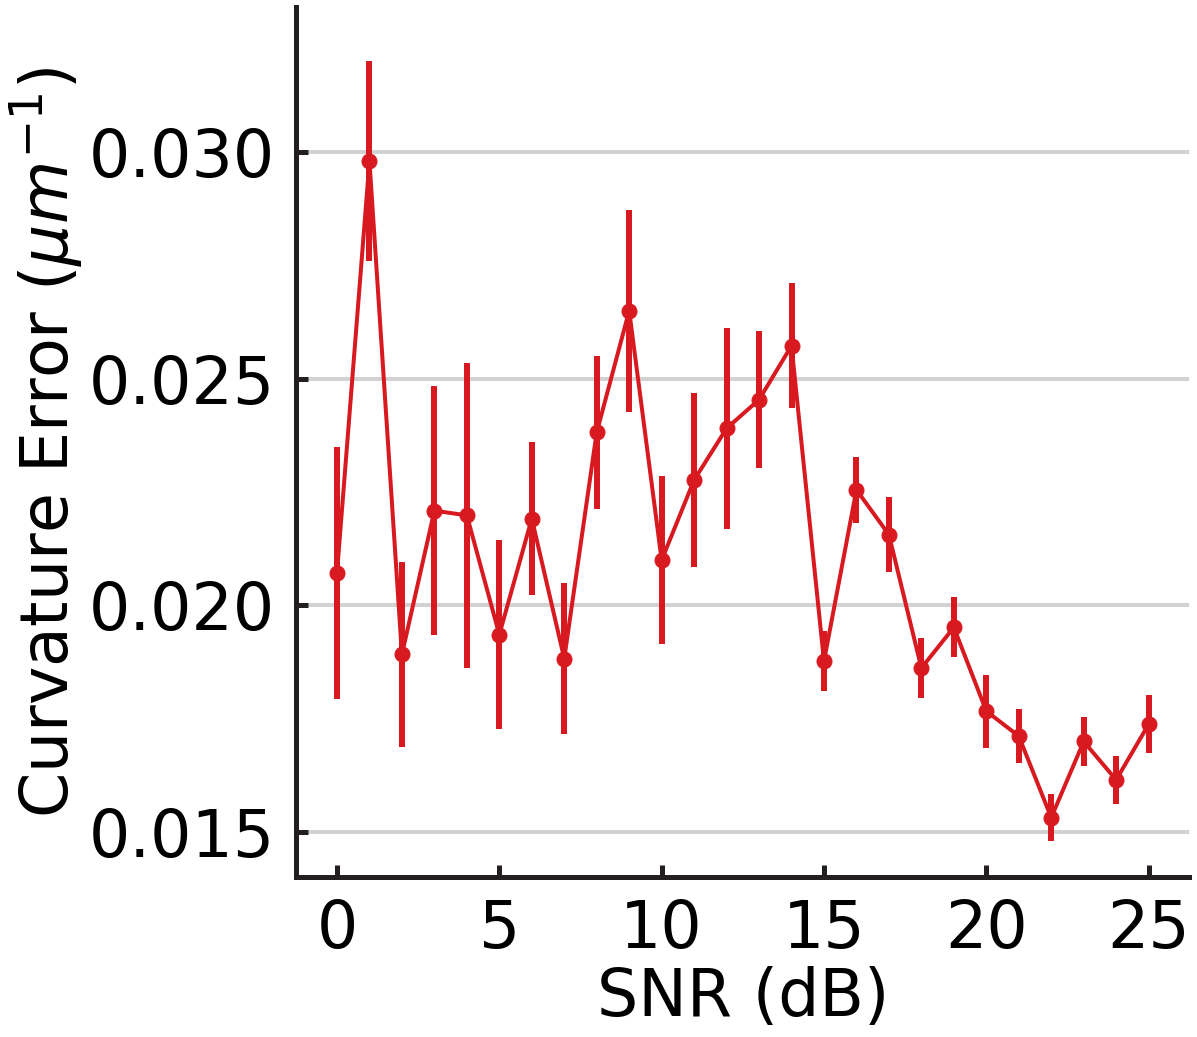

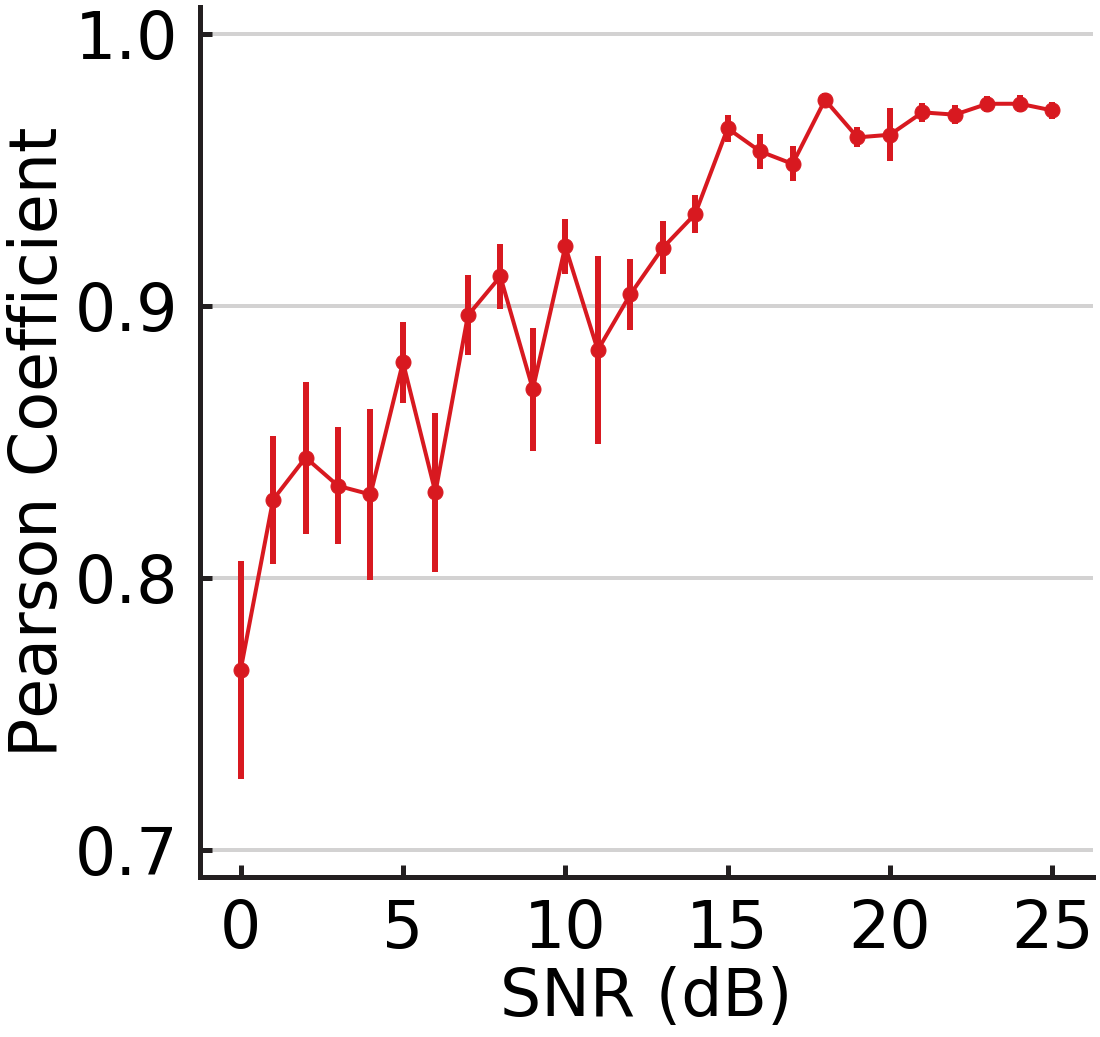

In [6]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['k'] - theoretical_sampled['k'].mean()).abs()
grouped = grouped.reset_index()

base_size = 16
x_label = "SNR (dB)"
x_ticks = np.arange(0, 26, 5)
x_lim = None
color = "#d81920"
labels_spacing = 0.02

#plt.ioff()

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.04, 0.005)
y_lim = (0.014, 0.0332)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.6, 1.2, 0.1)
y_lim = (0.69, 1.01)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#plt.ion()

---
## Analyze the "Variable Pixel Size" dataset

In [13]:
experiment_name = 'variable_pixel_size'
feature_type = float

path_dir = data_dir / experiment_name
fnames = list(path_dir.glob("*.tif"))

data = pd.DataFrame()
for fname in tqdm(fnames, total=len(fnames)):
    
    # Load curvatures
    curvatures = pd.read_csv(fname.with_suffix('.csv'))

    # Get sampled theoretical curve
    new_x = np.arange(0, 15, 0.01)  # um
    theoretical_sampled = pykappa.analysis.get_theoretical_sampled(new_x, theoretical_curvatures_path)

    # Get sampled curves and residuals
    results = pykappa.analysis.get_sampled_and_residuals(curvatures, theoretical_sampled, fname, feature_type)
    
    # Average values by curve name
    datum = results.groupby('curve_name').mean()
    
    # Compute Pearson coefficient for each curve
    datum['pearson_coef'] = results.groupby('curve_name').apply(lambda x: theoretical_sampled["k"].corr(x["k"], method='pearson'))
    
    data = data.append(datum.reset_index())

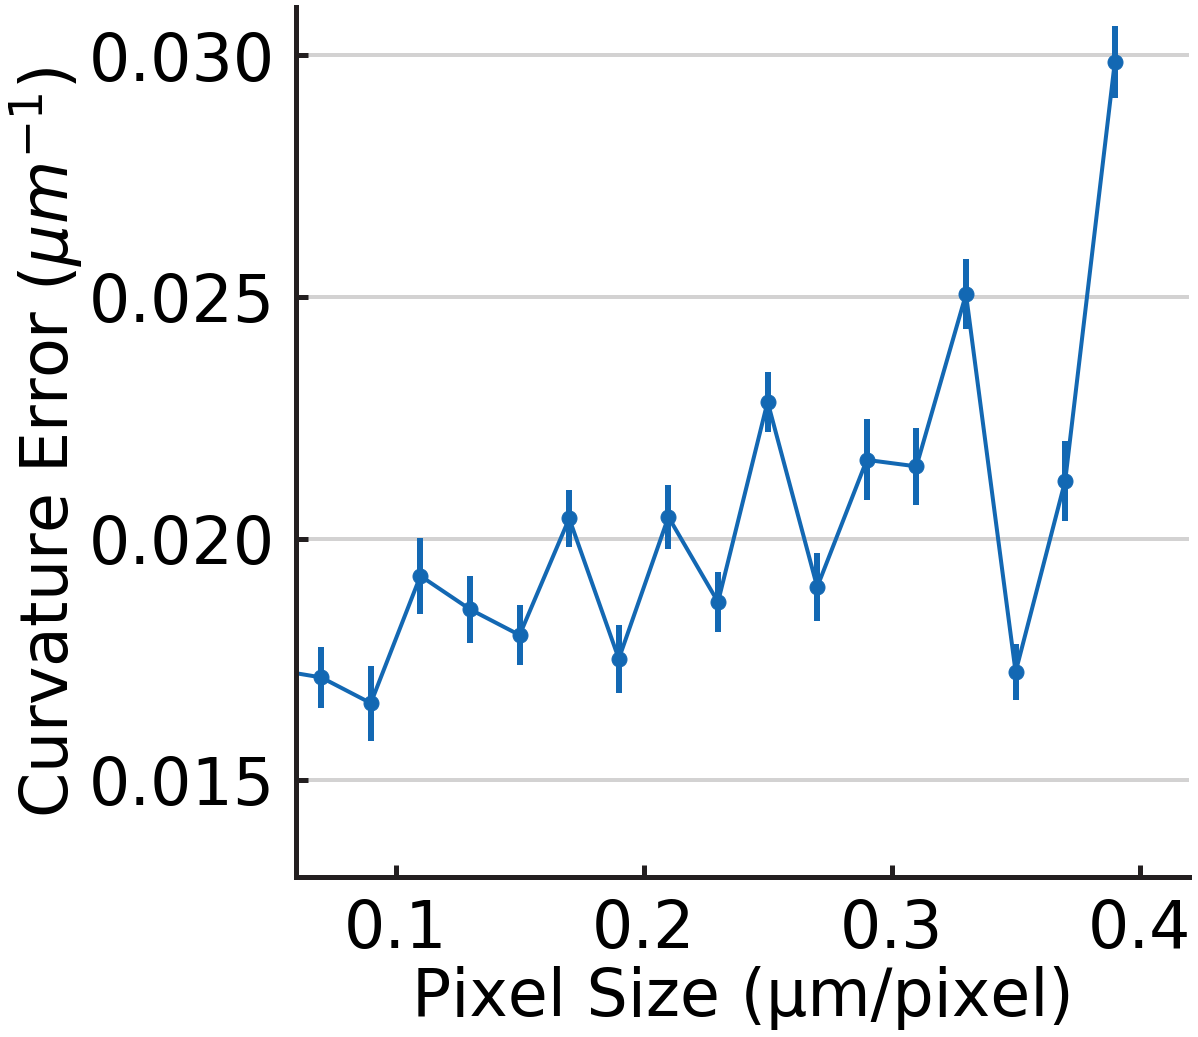

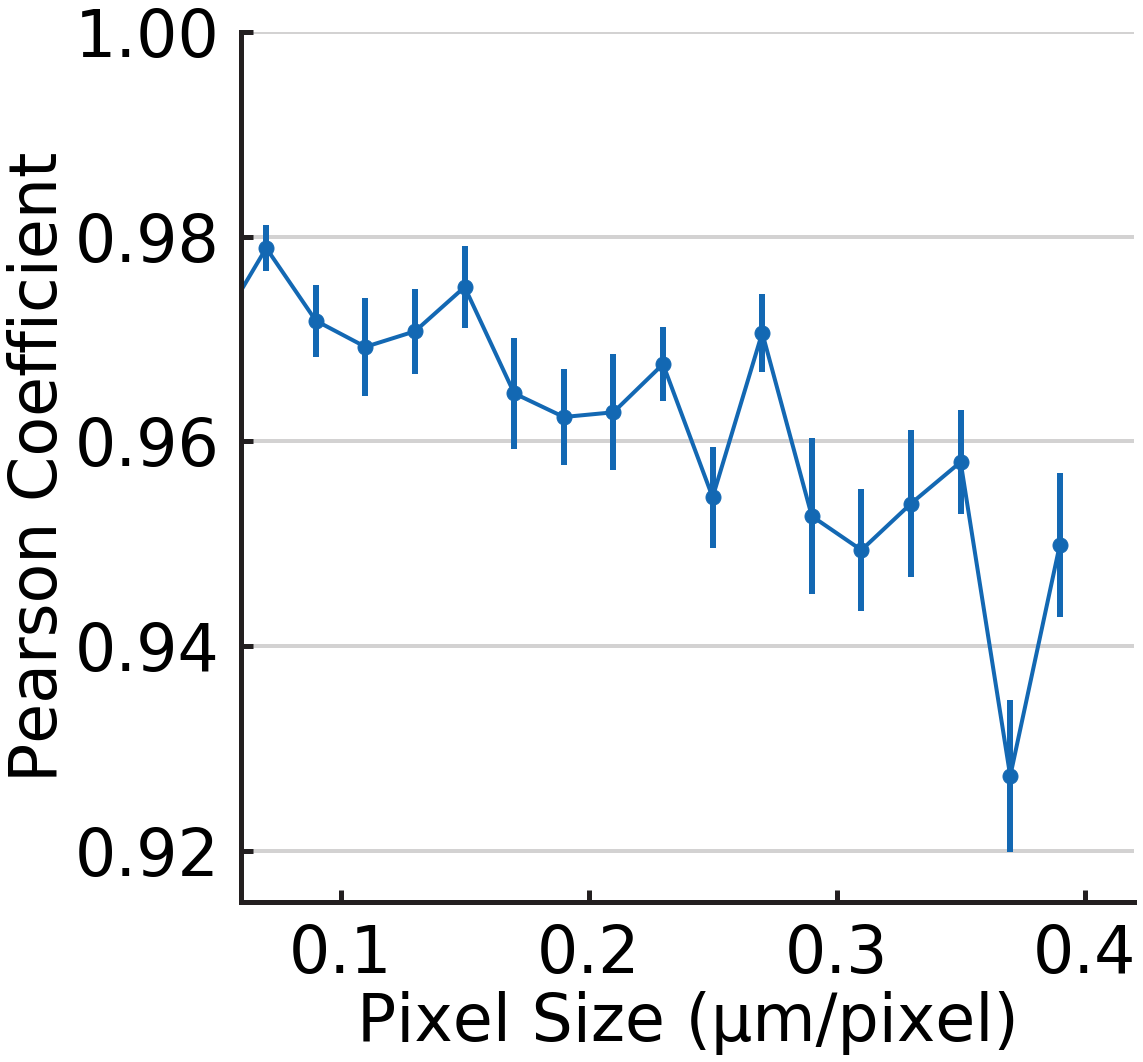

In [17]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['k'] - theoretical_sampled['k'].mean()).abs()
grouped = grouped.reset_index()

base_size = 16
x_label = "Pixel Size (μm/pixel)"
x_ticks = np.arange(0, 0.42, 0.1)
x_lim = (0.06, 0.42)
color = "#1368b3"
labels_spacing = 0.02

#plt.ioff()

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.04, 0.005)
y_lim = (0.013, 0.031)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.9, 1.1, 0.02)
y_lim = (0.915, 1)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

plt.ion()

---
## Analyze the "Variable Initial Curve" dataset

In [18]:
experiment_name = 'variable_initial_position'
feature_type = float

path_dir = data_dir / experiment_name
fnames = list(path_dir.glob("*.tif"))

data = pd.DataFrame()
for fname in tqdm(fnames, total=len(fnames)):
    
    # Load curvatures
    curvatures = pd.read_csv(fname.with_suffix('.csv'))

    # Get sampled theoretical curve
    new_x = np.arange(0, 15, 0.01)  # um
    theoretical_sampled = pykappa.analysis.get_theoretical_sampled(new_x, theoretical_curvatures_path)

    # Get sampled curves and residuals
    results = pykappa.analysis.get_sampled_and_residuals(curvatures, theoretical_sampled, fname, feature_type)
    
    # Average values by curve name
    datum = results.groupby('curve_name').mean()
    
    # Compute Pearson coefficient for each curve
    datum['pearson_coef'] = results.groupby('curve_name').apply(lambda x: theoretical_sampled["k"].corr(x["k"], method='pearson'))
    
    data = data.append(datum.reset_index())

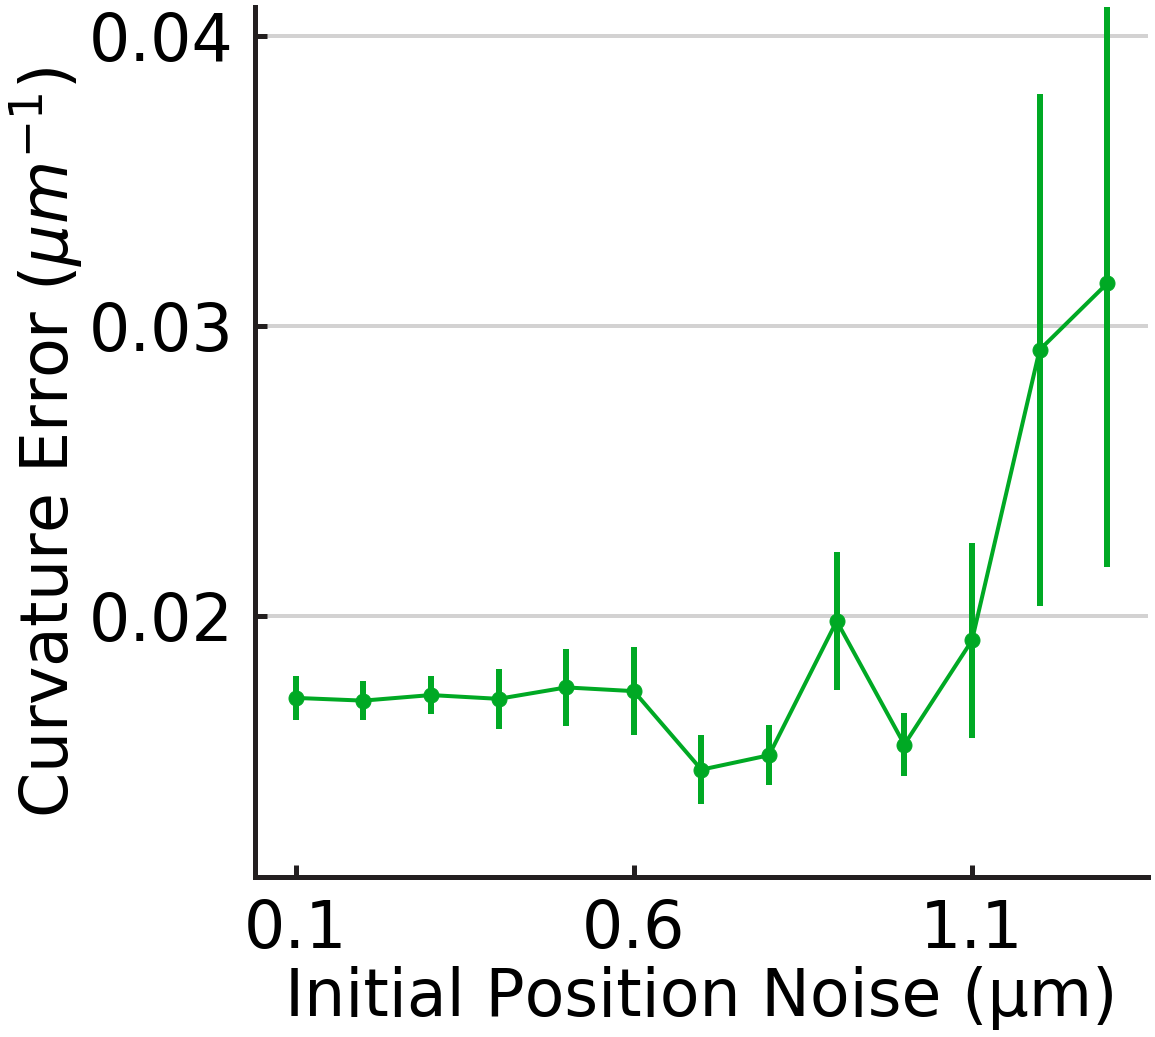

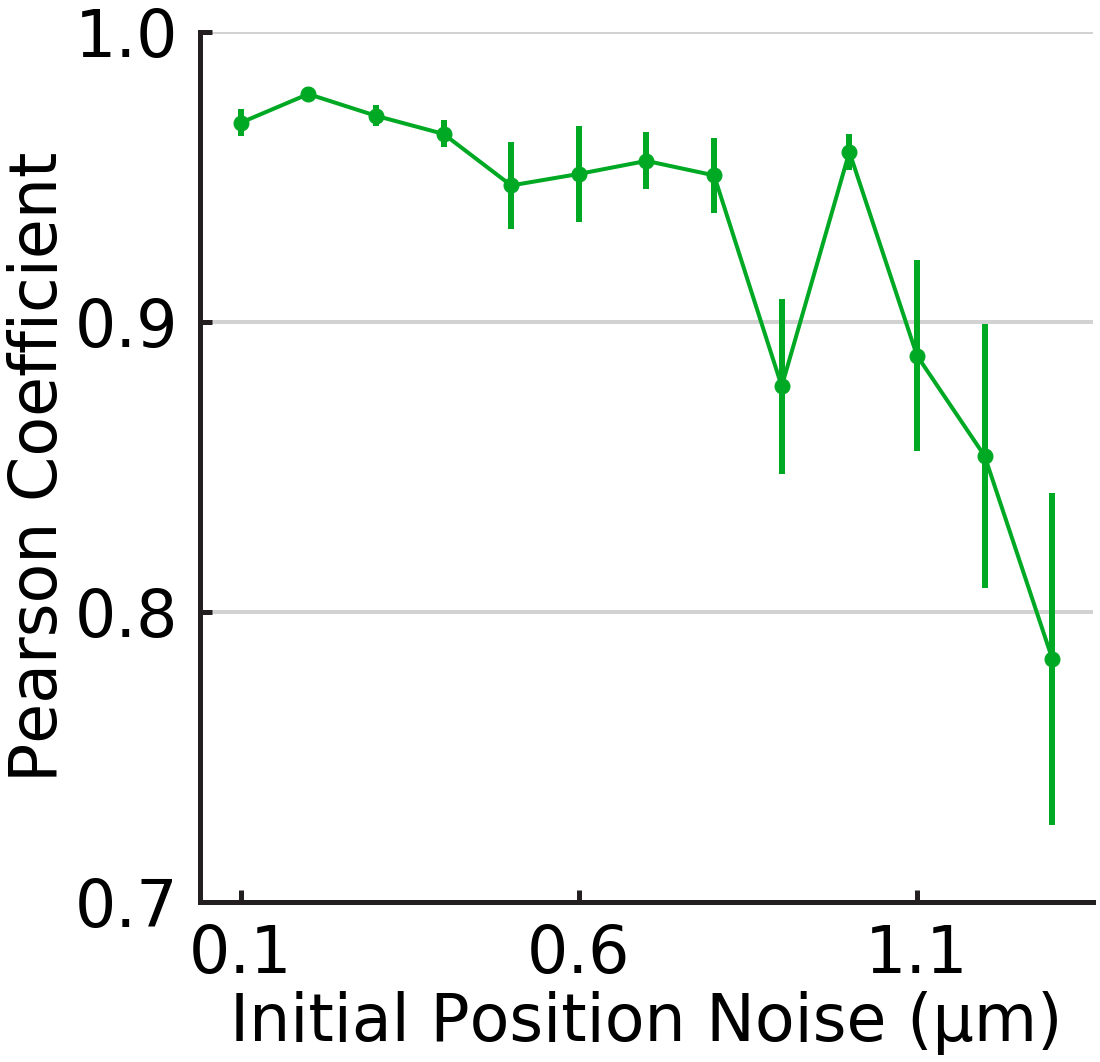

In [20]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['k'] - theoretical_sampled['k'].mean()).abs()
grouped = grouped.reset_index()

base_size = 16
x_label = "Initial Position Noise (μm)"
x_ticks = np.arange(0.1, 1.6, 0.5)
x_lim = None
color = "#00a924ff"
labels_spacing = 0.02

#plt.ioff()

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.08, 0.01)
y_lim = (0.011, 0.041)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.7, 1.1, 0.1)
y_lim = (0.7, 1)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

plt.ion()

---
## Analyze the "Variable PSF Size" dataset

In [2]:
experiment_name = 'variable_psf_size'
feature_type = float

path_dir = data_dir / experiment_name
fnames = list(path_dir.glob("*.tif"))

data = pd.DataFrame()
for fname in tqdm(fnames, total=len(fnames)):
    
    # Load curvatures
    curvatures = pd.read_csv(fname.with_suffix('.csv'))

    # Get sampled theoretical curve
    new_x = np.arange(0, 15, 0.01)  # um
    theoretical_sampled = pykappa.analysis.get_theoretical_sampled(new_x, theoretical_curvatures_path)

    # Get sampled curves and residuals
    results = pykappa.analysis.get_sampled_and_residuals(curvatures, theoretical_sampled, fname, feature_type)
    
    # Average values by curve name
    datum = results.groupby('curve_name').mean()
    
    # Compute Pearson coefficient for each curve
    datum['pearson_coef'] = results.groupby('curve_name').apply(lambda x: theoretical_sampled["k"].corr(x["k"], method='pearson'))
    
    data = data.append(datum.reset_index())
    
# Don't use data with no PSF
#data = data[data.feature != 0]

In [29]:
grouped.groupby('feature').mean()

,x,k,residuals,residuals_absolute,pearson_coef,average_error
feature,,,,,,
0.00,7.495,0.257692,-0.001029,0.019525,0.994696,0.009864
0.05,7.495,0.257614,-0.001085,0.024045,0.991746,0.009786
0.20,7.495,0.261647,-0.002161,0.035374,0.984265,0.013819
0.30,7.495,0.264433,-0.004037,0.047898,0.976207,0.016605
0.60,7.495,0.267829,-0.003755,0.065916,0.943002,0.020000
0.80,7.495,0.268641,-0.002544,0.076789,0.928244,0.020812
1.00,7.495,0.265076,0.002495,0.108386,0.846013,0.017664


In [10]:
theoretical_sampled['k'].mean()

0.2478281559235648

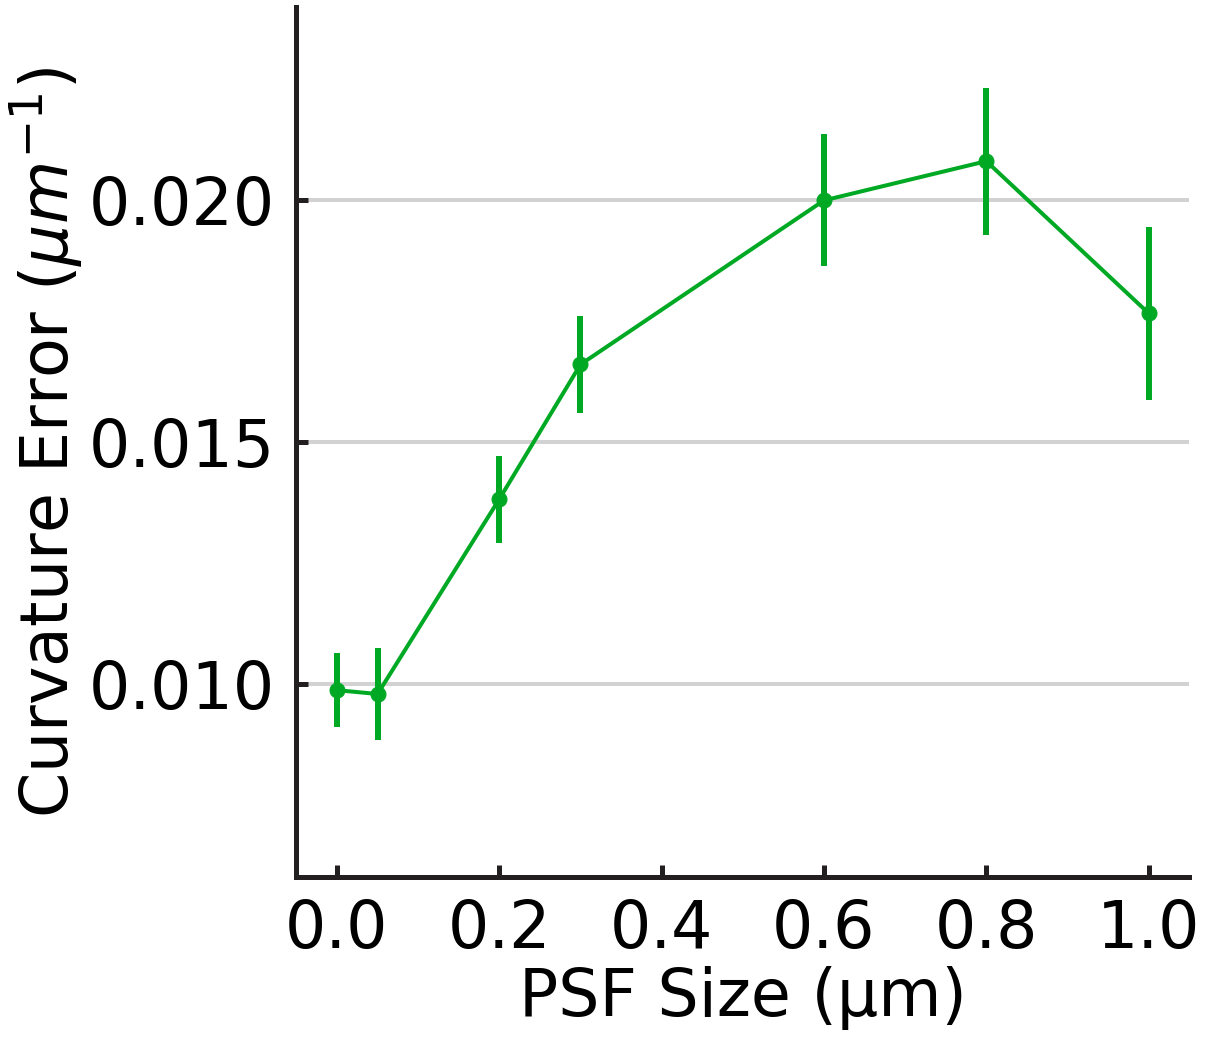

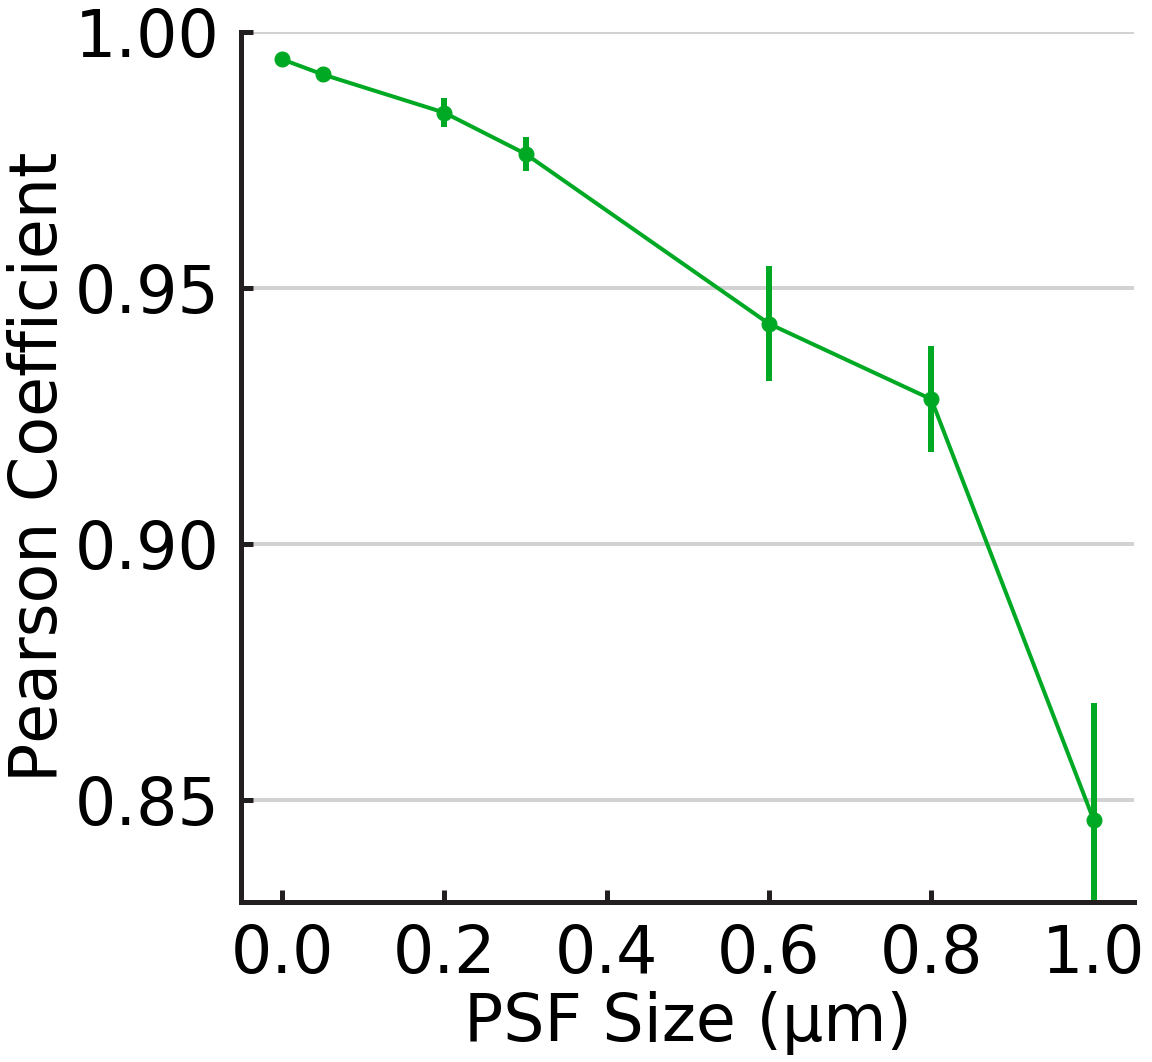

In [33]:
grouped = data.groupby(['feature', 'curve_name']).mean()
grouped['average_error'] = (grouped['k'] - theoretical_sampled['k'].mean()).abs()
grouped = grouped.reset_index()

base_size = 16
x_label = "PSF Size (μm)"
x_ticks = np.arange(0, 1.1, 0.2)
x_lim = None
color = "#00a924ff"
labels_spacing = 0.02

#plt.ioff()

# Plot absolute error
metric_label = 'average_error'
metric_name = "Curvature Error ($μm^{-1}$)"
y_ticks = np.arange(0, 0.08, 0.005)
y_lim = (0.006, 0.024)
fig = pykappa.mpl.plot_error(grouped, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Plot pearson coeff
metric_label = 'pearson_coef'
metric_name = "Pearson Coefficient"
y_ticks = np.arange(0.80, 1.1, 0.05)
y_lim = (0.83, 1.0)
fig = pykappa.mpl.plot_error(data, metric_label,
                             x_ticks, y_ticks,
                             x_label, metric_name,
                             x_lim, y_lim, color)
fig_name = f"{experiment_name}_{metric_label}.svg"
figure_path = figure_dir / fig_name
fig.savefig(figure_path, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#plt.ion()

---

Theoretical curvature at one specific point

In [27]:
import numpy as np

A = 6
T = 15
B = 2 * np.pi * (1/T)

x = 3.75
(A * B**2 * np.sin(B*x)) / ((1 + A**2*B**2*np.cos(B*x)**2)**(3/2))

1.0527578027828648

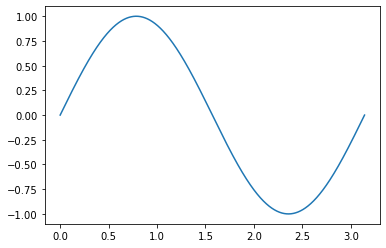

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

A = 1
T = np.pi

x = np.linspace(0, T, 10000)
y = A * np.sin(2 * np.pi * (1/T) * x)

plt.plot(x, y)

In [30]:
x[np.argmax(y)]

0.7854767110685552

In [31]:
np.pi/4

0.7853981633974483